# Máltækni - Náttúruvernd

# Data import & manipulation

In [38]:
from numpy.random import default_rng
import re
import tqdm
import pandas as pd
import pickle
import numpy as np
import string

import matplotlib.pyplot as plt

In [5]:
#@Vésteinn
def read_news_tsv(file_name):
    data = []
    with open(file_name, encoding="utf-8") as fh:
        for line in tqdm.tqdm(fh.readlines()):
            title, author, url, timestamp, _, _, text, text_tokenized = line.split("\t")
            article = {
                "title": title,
                "author": author,
                "timestamp": timestamp,
                "text": text,
                "text_tokenized": text_tokenized
            }
            data.append(article)
        return data

In [6]:
articles = read_news_tsv("icelandic_news_sample_22480.tsv")
print(f"Article count {len(articles)}")

100%|██████████| 22248/22248 [00:00<00:00, 246794.24it/s]

Article count 22248


In [7]:
articles_df = pd.DataFrame(articles)

In [8]:
articles_Big = read_news_tsv("articles_until_01-11-2020_detok.tsv")
print(f"Article count {len(articles_Big)}")

100%|██████████| 640136/640136 [00:05<00:00, 108411.62it/s]


Article count 640136


In [9]:
news_Big = pd.DataFrame(articles_Big)

In [10]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(news_Big, test_size = 0.15, random_state=11)

In [11]:
print(f'Training data examles: {data_train.shape[0]}')
print(f'Test data examles: {data_test.shape[0]}')

Training data examles: 544115
Test data examles: 96021


In [12]:
data_test, data_test_labeled = train_test_split(data_test, test_size = 0.005, random_state=11)

In [13]:
print(f'Test data examles: {data_test.shape[0]}')
print(f'Labeled test data examles: {data_test_labeled.shape[0]}')

Test data examles: 95540
Labeled test data examles: 481


In [14]:
# Subset af training til að koma virkni í gang án þjálfunartíma
_, data_playground = train_test_split(data_train, test_size = 0.10, random_state=11)
print(f'Playground data examles: {data_playground.shape[0]}')

Playground data examles: 54412


In [138]:
timabil = pd.to_datetime(data_playground['timestamp'])

In [141]:
timabil.sort_values()

629469   2009-08-18 07:54:00
19518    2011-06-19 23:41:05
100397   2011-07-06 19:27:37
394098   2011-08-03 12:37:29
62835    2011-09-15 13:09:48
                 ...        
451924   2020-11-02 11:51:00
451940   2020-11-02 11:54:00
452056   2020-11-02 12:11:39
452335   2020-11-02 12:36:00
452344   2020-11-02 12:51:06
Name: timestamp, Length: 54412, dtype: datetime64[ns]

# Skriftupælingar

In [21]:
# Skoðar 'count' margar handahófskenndar fréttir og skilar lista af
# algildum indexum fyrir þær fréttir sem innihalda 'náttúruvernd', 'loftslag' eða 'umhverfi'
def rand_frett(safn, count):
    listi = []
    from numpy.random import default_rng
    import re
    rng = default_rng()
    n = safn.shape[0]
    for i in tqdm.trange(count):
        x = rng.integers(n)
        if pd.isnull(safn.iloc[x]["text"]):
            continue
        frett = safn.iloc[x]["text"] # ath iloc
        frettnr = safn.iloc[x].name
        lykilord = ["náttúruvernd", "loftslag", "umhverfi"]
        fjoldi = 0
        for wrd in lykilord:
            fjoldi += len(re.findall(wrd, frett))
        if fjoldi > 0:
            listi.append(frettnr) # Ath. algildur index
            #print(frett)
    return listi

In [22]:
# Skoðar allar fréttir í gefnu safni og skilar lista með algildum indexum 
# á þeim fréttum sem innihalda fleiri en 'threshold' fjölda af 'náttúruvernd', 'loftslag' eða 'umhverfi'
def allar_frettir(safn, threshold=0):
    listi = []

    n = safn.shape[0]
    for i in tqdm.trange(n):
        frett = safn.iloc[i]["text"]
        lykilord = ["náttúruvernd", "loftslag", "umhverfi"]
        fjoldi = 0
        for wrd in lykilord:
            fjoldi += len(re.findall(wrd, frett))
        if fjoldi > threshold:
            listi.append(i) # ath. afstæð númer m.v. safn
            #print(frett)
    return listi 

In [23]:
# Athuga hvaða hlutfall kemur út úr síunni
sample_count = 100000
big_list = rand_frett(news_Big, sample_count)
print(len(big_list)/sample_count)

100%|██████████| 100000/100000 [00:26<00:00, 3791.55it/s]

0.06697


## Merkjum data_test_labeled

In [24]:
sigtaðar_frettir = allar_frettir(data_test_labeled)

100%|██████████| 481/481 [00:00<00:00, 8975.74it/s]


In [25]:
for fr in sigtaðar_frettir[:3]:
    print(data_test_labeled.iloc[fr])

title             Fyrst var hún hötuð en í dag er hún daglegt brauð
author                                       Ritstjórn Hringbrautar
timestamp                                       2019-04-28 21:09:00
text              (Á mynd: Áður en p-pillan og aðrar getnaðarvar...
text_tokenized    ( Á mynd : Áður en p-pillan og aðrar getnaðarv...
Name: 605530, dtype: object
title                                 „Sá glæsilegasti frá upphafi“
author                                             Ritstjórn mbl.is
timestamp                                       2020-09-05 09:36:00
text              „Veturinn fram undan verður sá þéttasti og glæ...
text_tokenized    „ Veturinn fram undan verður sá þéttasti og gl...
Name: 396081, dtype: object
title                 Tekur við kyndlinum sem tenging við umheiminn
author                                        Bergsteinn Sigurðsson
timestamp                                       2017-04-19 20:15:41
text              Hús sem gert er í nafni Vigdísar Finnbogad

In [26]:
len(sigtaðar_frettir)

38

In [27]:
# for i in sigtaðar_frettir[:3]:
#     frett = data_test_labeled.iloc[i]
#     print(frett["text"])
#     print(frett["title"])
#     einkunn = input("Um náttúruvernd?\n")
#     if einkunn == str(1):
#         ja.append(frett.name)
#     elif einkunn == str(2):
#         vafi.append(frett.name)
#     else:
#         annad.append(frett.name)

In [28]:
# Niðurstöður
jakvætt = {165133,322727,343386,233961,500609,327615}

# !! ATH breyta hér, flokka bara þau sem eru handyfirfarin sem neikvæð 
neikvætt = set(data_test_labeled.index).difference(jakvætt)

print(len(neikvætt))
print(len(jakvætt))
print(data_test_labeled.shape[0])

# data_test_labeled["label"] = np.zeros((len(data_test_labeled), 1), dtype = np.int8)
# for i in jakvætt:
#     data_test_labeled.loc[i,"label"] = 1
# for fr in big_list[:10]:
#     print(news_Big.loc[fr])

475
6
481


## Merkjum data_train

In [94]:
# 'vistaðar niðurstöður' úr flokkun að neðan.
# jákvæðar fréttir úr train
ja =    {285192, 531728, 543888, 290583, 624031, 620326, 586792, 300335, 615601, 57271, 541114, 232512, 203202, 565829, 402387, 212309, 563685, 207852, 319984, 338039, 551033}
# fréttir sem eru kannski já, kannski ekki
vafi =  {188673, 253189, 582670, 549263, 580500, 196829, 138785, 201385, 146412, 624949, 467836, 18621}
# Neikvæðar fréttir sem komu úr síunni
annad = {425218, 398339, 232836, 377475, 40966, 108040, 61449, 411913, 441611, 188049, 594451, 357913, 389534, 447519, 403616, 598944, 403230, 438562, 383270, 300455, 260392, 545578, 245419, 496045, 280365, 111155, 77492, 616884, 26553, 598717, 397246, 264765, 180800, 353226, 292173, 217422, 53844, 179030, 306134, 524889, 622682, 288093, 557662, 146272, 471780, 628965, 111590, 180717, 506996, 129525, 423028, 19063, 409848, 290171}
# # Neikvæðar fréttir teknar af handahófi úr train
neinei = {41758, 45206, 94336, 122610, 133607, 152981, 190982, 210392, 235700, 258454, 276324, 294168, 303348, 328102, 333446, 344739, 351967, 356145, 376980, 426847, 429708, 437621, 460035, 461629, 524825, 566916, 581492, 612748, 631359, 631908}
possibly_corrupt = {628965, 409848, 549263}
print(ja, vafi, annad, sep="\n")
print(len(ja))

{232512, 203202, 565829, 285192, 531728, 543888, 402387, 212309, 290583, 338039, 624031, 563685, 620326, 586792, 207852, 300335, 319984, 615601, 57271, 551033, 541114}
{188673, 138785, 253189, 201385, 146412, 582670, 549263, 580500, 624949, 196829, 467836, 18621}
{425218, 398339, 232836, 377475, 40966, 108040, 61449, 411913, 441611, 188049, 594451, 357913, 389534, 403230, 403616, 598944, 438562, 447519, 383270, 300455, 260392, 545578, 245419, 496045, 280365, 111155, 77492, 616884, 26553, 598717, 397246, 264765, 180800, 353226, 292173, 217422, 53844, 179030, 306134, 524889, 622682, 288093, 557662, 146272, 471780, 628965, 111590, 180717, 506996, 129525, 423028, 19063, 409848, 290171}
21


In [30]:
def label(safn, sigti, count=-1):
    for nr, i in enumerate(sigti[:count]):
        if i in ja or i in vafi or i in annad:
            continue
        frett = safn.loc[i] # Gert er ráð fyrir global index
        print(f"Frétt nr. {nr}")
        print(frett["text"])
        print(frett["title"])
        einkunn = input("Um náttúruvernd?\n")
        print()
        if einkunn == str(1):
            ja.add(frett.name)
        elif einkunn == str(2):
            vafi.add(frett.name)
        elif einkunn == str(0):
            neinei.add(frett.name)
        else:
            annad.add(frett.name)

In [31]:
# label(data_train, data_train.index)

Sigta af handahófi úr train <br>
Flokka sigtað í já og nei<br>
flokka af handahófi úr ósigtuðu (svo nei sé ekki bara sigtað nei)<br>
    - kannski í sér hóp til að sjá hvort það endurspeglist í flokkunum?<br>
Þegar það eru komnir nokkrir tugir í já, þá athuga hvar flokkaða lendir í LDA<br>
Kannski finna gögn sem eru sérstaklega um náttúruvernd, fréttir frá samtökum, Sólin, ...<br>

In [32]:
slembsigti = rand_frett(data_train, 2000) # Hefði kannski átt að setja seed?

100%|██████████| 2000/2000 [00:00<00:00, 3672.20it/s]


In [33]:
# label(data_train, slembsigti)

In [34]:
playground_sigti = allar_frettir(data_playground, 5)

100%|██████████| 54412/54412 [00:04<00:00, 11434.34it/s]


In [35]:
len(playground_sigti)

229

# GENSIM LDA pælingar

In [85]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [86]:

stop_words = set()
extra_stop_words = ["var", "er", "ekki", "sé"]
with open("is_stop_words.txt") as stop_word_file:
    for line in stop_word_file.readlines():
        stop_words.add(line.strip())
stop_words.update(set(string.punctuation))
stop_words.update(set(extra_stop_words))

In [87]:
import tokenizer
from islenska import Bin

b = Bin()

def naive_bin_lemma(token):
    candidates = b.lookup_lemmas_and_cats(token)
    if not candidates:
        return None
    if len(candidates) > 1:
        return None
    cand = candidates.pop()
    if cand[1] not in ["kk", "kvk", "hk"]:
        return None
    return cand[0]


def tokenize_and_lemmatize(sentence):
    if pd.isnull(sentence): # Líklegast óþarft núna
            return []
    tokenized_text = list(tokenizer.split_into_sentences(sentence))
    lemmas = []
    for sent in tokenized_text:
        for token in sent.split():
            if token in stop_words:
                continue
            lemma = naive_bin_lemma(token.lower())
            if lemma is not None: # bæta við stop_words hér? and lemma not in stop_words
                lemmas.append(lemma)
    return lemmas

In [88]:
def load_all():
    with open('data_words.pickle', 'rb') as fh:
        data_words = pickle.load(fh)
    with open('data_words_bigrams.pickle', 'rb') as fh:
        data_words_bigrams = pickle.load(fh)
    with open('id2word.pickle', 'rb') as fh:
        id2word = pickle.load(fh)
    with open('corpus.pickle', 'rb') as fh:
        corpus = pickle.load(fh)
    lda_model = gensim.models.ldamulticore.LdaModel.load("Big_lda_model")
    
    return data_words, data_words_bigrams, id2word, corpus, lda_model

In [89]:
def build_all():
    data_words = [tokenize_and_lemmatize(a) for a in tqdm.notebook.tqdm(data_train["text_tokenized"])]

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    # See trigram example
    # print(trigram_mod[bigram_mod[data_words[0]]])
    data_words_bigrams = make_bigrams(tqdm.tqdm(data_words))
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=10, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

In [90]:
def save_all():
    with open('data_words.pickle', 'wb') as fh:
        pickle.dump(data_words, fh)
    with open('data_words_bigrams.pickle', 'wb') as fh:
        pickle.dump(data_words_bigrams, fh)
    with open('id2word.pickle', 'wb') as fh:
        pickle.dump(id2word, fh)
    with open('corpus.pickle', 'wb') as fh:
        pickle.dump(corpus, fh)
    lda_model.save("./Big_lda_model")

In [91]:
data_words, data_words_bigrams, id2word, corpus, lda_model = load_all()

## Tilraunir

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Sjáum orðin tengd ákveðnum flokk
[id2word[i[0]] for i in lda_model.get_topic_terms(6, topn=50)]

In [ ]:
# Fáum hóp ákveðins orðs í safninu
# Af hverju sýnir þetta fyrir fæst orð?
lda_model.get_term_topics(id2word.token2id["króna"])

In [ ]:
sport = """„Úrslitin eru það mikilvægasta sem við tökum með okkur úr leik kvöldsins. Það er afrek að vinna Porto á útivelli. Að sigra eins og við sigruðum gerir sigurinn enn sætari,“ sagði Jürgen Klopp að loknum 5-1 sigri Liverpool á Drekavöllum í kvöld.
„Það var mikið af góðum augnablikum í leik kvöldsins. Við gátum séð að Porto horfði á leikinn okkar gegn Brentford þar sem þeir voru mjög beinskeyttir, ég vildi lagfæra það á vellinum og við gerðum það skref fyrir skref.“
"""
sport = tokenize_and_lemmatize(sport)

In [ ]:
covid= """Í gær greindust 36 einstaklingar innanlands með Covid-19 og voru 28 í sóttkví við greiningu. Tuttugu voru óbólusettir. 348 einstaklingar eru í einangrun hér á landi vegna sjúkdómsins og 1.164 í sóttkví. """
covid=tokenize_and_lemmatize(covid)

In [92]:
def classify(text, verbose=False):
    bow_vector = id2word.doc2bow(text)
    #print(lda_model[bow_vector])
    for index, score in sorted(lda_model[bow_vector][0], key=lambda tup: -1*tup[1]):
        if verbose:
            print("Cluster: {}\t Score: {}\t Topic: {}".format(index, score, lda_model.print_topic(index, 5)))
    if verbose:
        print()
    return(lda_model[bow_vector][0])

In [93]:
def lda_group(indexes, verbose=False):
    mat = np.zeros((len(indexes), 10), dtype=np.float32)
    for i, example in enumerate(tqdm.tqdm(indexes)):
        text = data_train.loc[example]["text_tokenized"] # getur verið news_Big fyrir öll dæmin
        lemm_text = tokenize_and_lemmatize(text)
        vec = classify(lemm_text)
        for group, score in vec:
            mat[i, group] = score
    score_sum = np.sum(mat, axis=0)
    if verbose:
        print(score_sum)
        prin3t(score_sum/sum(score_sum))
        print(-np.sort(-score_sum))
        print(np.argsort(-score_sum))
    return mat

In [95]:
jalist = list(ja)

In [96]:
ja_mat = lda_group(jalist, False)

100%|██████████| 21/21 [00:01<00:00, 16.86it/s]


In [103]:
tops = np.argmax(ja_mat, axis=1)

In [106]:
np.bincount(tops)

#top_d = dict()
#for item in tops:
#    count = tops.count(item)
#    top_d[item] = count

array([ 1,  0,  0,  4,  0,  0, 12,  0,  4])

In [ ]:
# atta = [3,6,19,20]
# þristur = [8,12,15,16]
# sexa = [1,2,4,5,7,8,9,10,11,13,14,17]
# 
# for i in atta:
#     print(data_train.loc[jalist[i]]["title"])
# print()
# for i in þristur:
#     print(data_train.loc[jalist[i]]["title"])
# print()
# for i in sexa:
#     print(data_train.loc[jalist[i]]["title"])

In [52]:
neineilist = list(neinei)
nei_mat = lda_group(neineilist)
np.argmax(nei_mat, axis=1)

NameError: name 'lda_group' is not defined

In [135]:
data_train.loc[neineilist[2]]

title                           Smit virðast dreifð víða á Akureyri
author                                           Urður Örlygsdóttir
timestamp                                       2020-10-28 17:48:00
text              Um helgina kom upp smit á Norðurlandi eystra s...
text_tokenized    Um helgina kom upp smit á Norðurlandi eystra s...
Name: 566916, dtype: object

In [129]:

def visual_groups(mat, save=None):
    vigur = np.sum(mat, axis=0)
    plt.bar(list(range(10)), vigur)
    plt.show()
    
    plt.bar(range(len(vigur)), -np.sort(-vigur))
    plt.xticks(range(len(vigur)), np.argsort(-vigur))
    if save:
        plt.savefig("./pics/"+save+"_summa.jpg")
    plt.show()

    
    tops = np.argmax(mat, axis=1)
    counts = np.bincount(tops)
    plt.bar(range(len(counts)), counts)
    plt.show()

    # raða
    plt.bar(range(len(counts)), -np.sort(-counts))
    plt.xticks(range(len(counts)), np.argsort(-counts))
    if save:
        plt.savefig("./pics/"+save+"_top.jpg")
    plt.show()

100%|██████████| 12/12 [00:00<00:00, 19.47it/s]


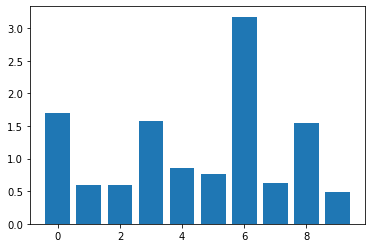

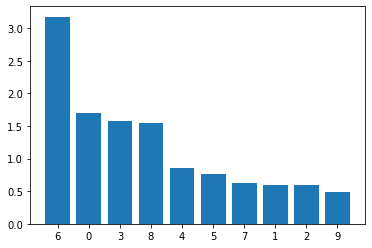

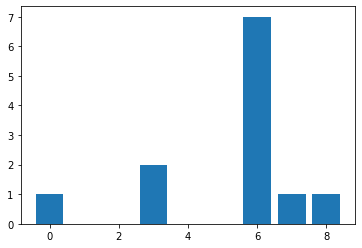

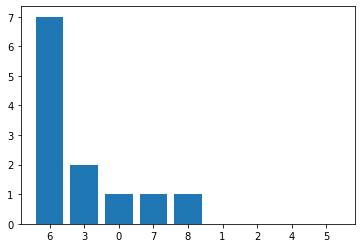

In [133]:
visual_groups(lda_group(vafi, False), "vafi")

In [ ]:
# Keyrir í tæpar 40 mín, stallar á 95% að því er virðist að eilífu
# playground_groups = lda_group(data_playground.index, True)

In [ ]:
# Pælingar á ís.

# for j in data_test_labeled[data_test_labeled["label"] == 1]["text"]:
#     classify(tokenize_and_lemmatize(j))
#     print(j, "\n")
# 
# data_test_labeled[data_test_labeled["label"] == 0][:10]["text"]
# for nei in data_test_labeled[data_test_labeled["label"] == 0][:10]["text"]:
#     classify(tokenize_and_lemmatize(nei))
#     print(nei, "\n")
# for nei in data_test_labeled[data_test_labeled["label"] == 0][:10]:
#     print(nei)
#     texti = nei["text"]
#     print(nei["title"])
#     classify(tokenize_and_lemmatize(texti))
#     print(texti, "\n")

# TF IDF pælingar

In [142]:
from gensim import models
from gensim import matutils
import time

In [143]:
tfidf = models.TfidfModel(corpus) # sami corpus og fyrir LDA
corpus_tfidf = tfidf[corpus] # lazy

In [144]:
lsi_200 = models.LsiModel.load("lsi_model_200")
corpus_lsi_200 = lsi_200[corpus_tfidf] 

In [145]:
lsi_500 = models.LsiModel.load("lsi_model_500")
corpus_lsi_500 = lsi_500[corpus_tfidf] 

In [ ]:
load = True
if not load:
    t = time.time()
    lsi_model = models.LsiModel(corpus_tfidf, id2word=id2word, num_topics=200)  
    corpus_lsi = lsi_model[corpus_tfidf] 
    print(time.time() - t)

In [124]:
data_train.loc[jalist[2]]["text"]
print(data_words[data_train.index.get_loc(2826)])


['neytendasamtök', 'leigjenda-aðstoð', 'leigjandi', 'íbúðarhúsnæði', 'samningur', 'félagsmálaráðuneyti', 'dagur', 'neytendasamtök', 'þjónusta', 'ár', 'ásmundur', 'félag', 'barnamála-ráðherra', 'samningur', 'formaður', 'neytendasamtök', 'samningur', 'áramót', 'þjónusta', 'samningur', 'leigjandi', 'íbúðarhúsnæði', 'upplýsing', 'húsaleigulög', 'ráðgjöf', 'ágreiningur', 'leigusamningur', 'íbúðarhúsnæði', 'þjónusta', 'leigjandi', 'leigjenda-aðstoð', 'símatími', 'þriðjudagur', 'upplýsing', 'réttindi', 'leigjandi', 'leigjenda-aðstoð']


In [147]:
topic_vector = ["friðland", "andrúmsloft", "umhverfissjónarmið", "loftslagsáhrif", "sjávarborð", "loftslagsvísindi", "ísöld", "náttúruhamfarir", "loftslagslíkan", "friðun", "loftslag-breyting", "umhverfisverndarsinni", "losun", "heildarlosun", "kol", "umhverfisverndarstofa", "umhverfisdómstóll", "auðlindaráðuneyti", "loftslagsstefna", "orkunotkun", "umhverfisskattur", "aðgerðasinni", "hamfarahlýnun", "skref", "útlosun", "lifnaðarháttur", "náttúruauðlind", "náttúruverndarlög", "umhverfisfræði", "orkugjafi", "loftslagsmál", "landnotkun", "úrgangur", "sóun", "útblástur", "gráðurhúsaáhrif", "stóriðja", "kolefnishlutleysi", "umhverfisþing", "umhverfisáhrif", "loftslagsbreyting", "súrnun", "sjór", "vistkerfi", "hringrásarhagkerfi", "sjálfbærni", "parísarsamkomulag", "gróðurhúsalofttegund", "loftslagsaðgerðir", "loftslagsvá", "náttúruvernd", "loftslag", "umhverfi", "náttúra", "hlýnun", "jörð", "loftslagsráðstefna", "þjóðgarður", "bráðna", "jökull", "umhverfisvernd", "mengun", "jarðefnaeldsneyti", "náttúruverðmæti"]
topic_vector.sort()
t = lsi_500[tfidf[id2word.doc2bow(topic_vector)]]
a = corpus_lsi_500[300]
# sama og 
# a = lsi_model[tfidf[corpus[300]]]
matutils.cossim(a, t)

0.02243280872289521

In [ ]:
lsi_200.print_topics(10)

In [ ]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
#logging.disable()


In [ ]:
#for doc, as_text in zip(corpus_lsi, data_train["text"][:55000]):
#    print(doc, as_text)
#

In [148]:
maxs, maxi = (-1,-1)
nbr = 10000
score_matrix = np.zeros((1,nbr))
for i in range(nbr):
    a = lsi_200[tfidf[corpus[i]]]
    sim = matutils.cossim(a,t)
    score_matrix[0, i] = sim
    if sim > maxs:
        maxs = sim
        maxi = i
print(maxs, maxi)

0.21654436374730263 3568


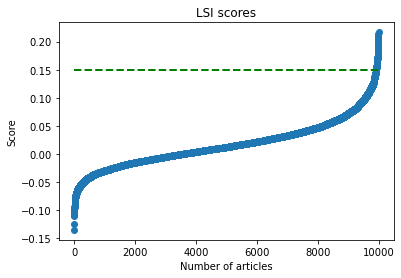

In [162]:
plt.scatter(range(nbr), np.sort(score_matrix))
plt.title("LSI scores")
plt.xlabel("Number of articles")
plt.ylabel("Score")
plt.plot([0, 10000], [0.15, 0.15],color='green',
         linestyle='dashed',linewidth=2)
plt.savefig("./pics/LSI.jpeg")
plt.show()

In [ ]:
topic_vector

In [153]:
included = list()
for i in range(10000):
    a = lsi_200[tfidf[corpus[i]]]
    sim = matutils.cossim(a,t)
    if sim > 0.15:
        included.append(i)
        #print(data_train.iloc[i]["title"])

In [156]:
len(included)/nbr

0.0079

In [154]:
for i in included:
    print(data_train.iloc[i]["title"])

Hitaveitan á Eskifirði hefur kólnað
„Holur hljómur í lífskjarasamningi“
Íslendingar neyslufrekasta þjóðin
Níu athugasemdir við fiskeldi á Kópaskeri
Ný rann­­sókn á plast­­­­magni á Suður­­skauts­landinu veldur á­hyggjum
Gera út á vísindamenn sem rannsaka loftlagsbreytingar
Vinna aðgerðaráætlun fyrir Vestfirði
Segir rótina að loftslagsbreytingum vera hið kapítalíska heimsskipulag
Uppbygging stóriðju var svar við ákalli samfélagsins
Græna leiðréttingin
75 ára afmæli lýðveldisins
Loftslagið og stjórnmál
Telur að kvikan sé grunnt undir yfirborði fjallsins
Vilja koma á raunverulegu þjóðarsamtali
Smári: „Virkjunin leysir engin vandamál sem eru raunverulega til staðar“
Vilja sporna við bráðnun
77 athugasemdir bárust vegna Svartárvirkjunar
Vilja fá að veiða í fleiri veiðarfæri
Trappist-sólkerfið talið ríkt af vatni

Regnskógur gæti breyst úr kolefnisforða í uppsprettu
Fundu forna borg í skóginum
Nákvæmustu loftslagslíkönin spá verstu afleiðingunum
Jarðvarmastöðin að Þeistareykjum gangsett
Loft

In [165]:
for i in jalist:
    a = corpus_lsi_200[data_train.index.get_loc(i)]
    sim = matutils.cossim(a,t)
    if sim>0.15:
        print(sim, data_train.loc[i]["title"])

0.1739648930036571 Kerfisbreytingar eiga að snúast um loftslagsbreytingar
0.17868665389682406 Hrygning bleikju hafin í vötnum landsins
0.21973680697966672 Vilja sóðaskatt og allir verði vegan
0.16047562550232397 Seiðaeldi hefur ekki áhrif á hverastrýtur


In [ ]:
data_train.loc[jalist[8]]["title"]

In [ ]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)


In [ ]:
query_document = topic_vector


In [ ]:
query_bow = id2word.doc2bow(query_document)


In [ ]:
# Krassar

# sims = index[tfidf[query_bow]]
# index.get_similarities(tfidf[id2word.doc2bow(topic_vector)])


In [ ]:
print(list(enumerate(sims)))

# NER

In [1]:
from transformers import AutoModelForTokenClassification
from transformers import pipeline
from transformers import AutoTokenizer
    
model = AutoModelForTokenClassification.from_pretrained("eliasbe/IceBERT-finetuned-ner")
tokenizerIce = AutoTokenizer.from_pretrained("eliasbe/IceBERT-finetuned-ner")
iceb = pipeline("ner", model=model, tokenizer=tokenizerIce)

In [2]:
modelX = AutoModelForTokenClassification.from_pretrained("eliasbe/XLMR-ENIS-finetuned-ner")
# Picked an arbitrary model_max_length to suppress truncation error, 
# not sure if this introduces other problems - KJP
tokenizerX = AutoTokenizer.from_pretrained("eliasbe/XLMR-ENIS-finetuned-ner", model_max_length=512)
xlmr = pipeline("ner", model=modelX, tokenizer=tokenizerX)

In [3]:
# Bypass for maximum length of xlmr model
def ner(text):
    length = len(text)
    half = length//2
    try:
        return xlmr(text)
    except:
        return ner(text[:half]) + ner(text[half:])

In [15]:
# Athuga að við viljum væntanlega halda utan um staðsetningu líka síðar

# Fall sem nær í nöfn úr texta
def get_names(text):
    l = list()
    end = -1
    beg = False
    for entry in ner(text):
        if entry['entity'] in {'B-Person', 'I-Person'}:                               
            word = entry['word'].strip() 
            if word in set(string.punctuation):
                end = int(entry['end'])
                continue
            if word[0] == '▁':
                word = word[1:]
                beg = True
            if end == int(entry['start']) and l:
                last = l[-1]
                if beg:
                    nxt = " ".join([last, word])
                else:
                    nxt = "".join([last, word])
                l = l[:-1]
                l.append(nxt)
            else:
                l.append(word)
            end = int(entry['end'])
        beg = False
    l = set(l)
    return l
            

In [17]:
# Convert a single name to nefnifall
def nefnifall_stk(nafn):
    out = list()
    temp = list()
    cats = list()
    nöfn = nafn.split()

    # Athuga ef nöfnin hafa mörg kyn, kjósa um það
    for n in nöfn:
        kyn = list(b.lookup_cats(n))
        for k in kyn:
            cats.append(k)
    if len(set(cats)) > 1:
        k = max(set(cats), key=cats.count)
    elif cats:
        k = cats[0]
    #print(k)

    # Setja nefnifallið í lista
    for n in nöfn:   
        try: # Fyrir erlend nöfn
            variant = b.lookup_variants(n, k, ("NF", "ET"))
        except:
            variant = None
        #print(variant)
        if variant: 
            if len(variant) > 1: # Ef til eru margar útfærslur á nafninu (Þór/Þórr) 
                same = False
                for v in variant:
                    if v.bmynd == n:
                        temp.append(n)
                        same = True
                        break
                    vb = v.bmynd
                if not same:
                    temp.append(vb)
            else:                    
                temp.append(variant[0].bmynd)
        else:
            temp.append(n)
    name_nf =" ".join(temp)
    return name_nf

# Convert a list of names to nf.
def nefnifall(nafnalisti):
    out = list()
    for nafn in nafnalisti:
        out.append(nefnifall_stk(nafn))
    return out

In [18]:
# Orðabók til að einræða flokka og sía út

flokkamap = {'Alþýðubandalag': 'Alþýðubandalagið',
 'Alþýðubandalagið': 'Alþýðubandalagið',
 'Alþýðuflokkur': 'Alþýðuflokkurinn',
 'Alþýðuflokkurinn': 'Alþýðuflokkurinn',
 'Borgaraflokkur': 'Borgaraflokkurinn',
 'Borgaraflokkurinn': 'Borgaraflokkurinn',
 'Borgarahreyfingin': 'Borgarahreyfingin',
 'Bændaflokkur': 'Bændaflokkurinn',
 'Flokkur fólksins': 'Flokkur fólksins',
 'Bændaflokkurinn': 'Bændaflokkurinn',
 'Framfaraflokkurinn': 'Framfaraflokkurinn',
 'Framsóknar': 'Framsóknarflokkurinn',
 'Framsóknarflokkur': 'Framsóknarflokkurinn',
 'Framsóknarflokkurinn': 'Framsóknarflokkurinn',
 'Frjálslyndi': 'Frjálslyndi',
 'Heimastjórnarflokkur': 'Heimastjórnarflokkurinn',
 'Heimastjórnarflokkurinn': 'Heimastjórnarflokkurinn',
 'Kommúnistaflokkurinn': 'Kommúnistaflokkurinn',
 'Landvarnarflokkurinn': 'Landvarnarflokkurinn',
 'Miðflokkurinn': 'Miðflokkurinn',
 'Píratar': 'Píratar',
 'Sambandsflokkurinn': 'Sambandsflokkurinn',
 'Sameiningarflokkur': 'Sameiningarflokkur',
 'Samfylkingin': 'Samfylkingin',
 'Sjálfstæðisflokkur': 'Sjálfstæðisflokkurinn',
 'Sjálfstæðisflokkurinn': 'Sjálfstæðisflokkurinn',
 'Sparnaðarbandalagið': 'Sparnaðarbandalagið',
 'Sósíalistaflokkur': 'Sósíalistaflokkurinn',
 'Sósíalistaflokkurinn': 'Sósíalistaflokkurinn',
 'Utanflokkabandalagið': 'Utanflokkabandalagið',
 'Vinstrihreyfingin': 'VG',
 'Vinstrihreyfingin - grænt framboð': 'VG',
 'Viðreisn': 'Viðreisn',
 'Íhaldsflokkurinn': 'Íhaldsflokkurinn',
 'Þjóðræðisflokkurinn': 'Þjóðræðisflokkurinn',
 'Þjóðvaki': 'Þjóðvaki',
 'Þjóðvarnarflokkurinn': 'Þjóðvarnarflokkurinn',
 'Kvennalistinn': 'Kvennalistinn',
 'vennalistinn': 'Kvennalistinn',
 'reisn': 'Viðreisn',
 'Björt framtíð': 'Björt framtíð', 
 'Björt': 'Björt framtíð',
 'Samtök um kvennalista': 'Samtök um kvennalista',
 'Samtök um jafnrétti og félagshyggju': 'Samtök um jafnrétti og félagshyggju',
 'þingflokkur jafnaðarmanna': 'þingflokkur jafnaðarmanna',
 'Samtök frjálslyndra og vinstri manna': 'Samtök frjálslyndra og vinstri manna',
 'Framfaraflokkur': 'Framfaraflokkurinn',
 'Framfaraflokkurinn': 'Framfaraflokkurinn', 
 'Bandalag jafnaðarmanna': 'Bandalag jafnaðarmanna',
 'ramsóknarflokkur': 'Framsóknarflokkurinn'             
}

In [19]:
# Fall til að sækja flokk úr texta, sér í lagi 'Alþingismenn.txt'

def get_party(text):
    l = list()
    end = -1
    beg = False
    for entry in ner(text):
        if entry['entity'] == 'B-Organization':                               
            word = entry['word']
            if word in set(string.punctuation):
                end = int(entry['end'])
                continue
            if word[0] == '▁':
                word = word[1:]
                beg = True
            if word[0] in set(string.punctuation):
                word = word[1:]
            if end == int(entry['start']):
                last = l[-1]
                if beg:
                    nxt = " ".join([last, word])
                else:
                    nxt = "".join([last, word])
                l = l[:-1]
                l.append(nxt)
            else:
                l.append(word) # Athuga með að sía fyrir raunverulegum flokkum
            end = int(entry['end'])
        beg = False
    out = set()
    for flokk in l:
        if flokk in flokkamap:
            out.add(flokkamap[flokk])
        #else:
        #    print("Party not found: ", flokk)
    
    # Bara fyrir alþingismannatalið
    if not out:
        party = re.findall("\(((?:\w|\s)*)\)\.", text)
        for p in party:
            if p in flokkamap:
                out.add(flokkamap[flokk])
            #else:
            #    print(p)
    return out
            

In [21]:
# https://www.althingi.is/altext/cv/is/
with open("Alþingismenn.txt", "r") as f:
    alþingi = f.readlines()

In [519]:
# Smíðar skrá sem geymir Nafn:flokkur fyrir alla fyrri alþingismenn

member_party = dict()
for sentence in alþingi:
    
    # ML methods
    member = get_names(sentence)
    party = get_party(sentence)

    
    #print(member, party)
    for m in member:  
        if m in member_party:
            member_party[m] = member_party[m].union(party)
        else:
            member_party[m] = party

In [22]:
re_member_party = dict()
for sentence in alþingi:
    
    member = re.findall("^\s*((?:\w|\s)*)\.", sentence)
    party = re.findall("\(((?:\w|\s)*)\)\.", sentence)
    
    p_list = list()
    for p in party:
        if p in flokkamap:
            p_list.append(flokkamap[p])
    party = set(p_list)
    
    #print(member, party)
    
    if member:
        if member[0] not in re_member_party:
            re_member_party[member[0]] = set(party)
        else:
            re_member_party[member[0]] = re_member_party[member[0]].union(set(party))
    else:
        print(sentence)

In [527]:
len(re_member_party)

1244

In [524]:
flokkar = set()
for it in member_party.values():
    for i in it:
        flokkar.add(i)

In [525]:
flokkar

{'Alþýðubandalagið',
 'Alþýðuflokkurinn',
 'Bandalag jafnaðarmanna',
 'Björt framtíð',
 'Borgaraflokkur',
 'Borgaraflokkurinn',
 'Borgarahreyfingin',
 'Bændaflokkurinn',
 'Flokkur fólksins',
 'Framfaraflokkurinn',
 'Framsóknarflokkur',
 'Framsóknarflokkurinn',
 'Frjálslyndi',
 'Heimastjórnarflokkurinn',
 'Kommúnistaflokkurinn',
 'Kvennalistinn',
 'Landvarnarflokkurinn',
 'Miðflokkurinn',
 'Píratar',
 'Sambandsflokkurinn',
 'Sameiningarflokkur',
 'Samfylkingin',
 'Samtök frjálslyndra og vinstri manna',
 'Samtök um jafnrétti og félagshyggju',
 'Samtök um kvennalista',
 'Sjálfstæðisflokkur',
 'Sjálfstæðisflokkurinn',
 'Sparnaðarbandalagið',
 'Sósíalistaflokkurinn',
 'Utanflokkabandalagið',
 'VG',
 'Viðreisn',
 'Íhaldsflokkurinn',
 'Þjóðræðisflokkurinn',
 'Þjóðvaki',
 'Þjóðvarnarflokkurinn',
 'þingflokkur jafnaðarmanna'}

In [528]:
oflokkadir = list()
flokkadir = list()
ath_linur = list()
for idx, key in enumerate(member_party):
    if not member_party[key]:
        oflokkadir.append(key)
        ath_linur.append(idx)
    else:
        flokkadir.append(key)

In [529]:
len(oflokkadir)/(len(flokkadir)+len(oflokkadir))

0.16323296354992076

In [531]:
len(oflokkadir) + len(flokkadir)
#len(alþingi)

1262

In [533]:
#for lina in range(len(ath_linur)):
#    print(alþingi[ath_linur[lina]], oflokkadir[lina], sep=" ")

In [80]:
data_train.loc[jalist[5]]

title                          Vilja sóðaskatt og allir verði vegan
author                                       Kristín Sigurðardóttir
timestamp                                       2017-09-10 17:38:45
text              Sóðaskattur, framleiðsla á áburði með ánamöðku...
text_tokenized    Sóðaskattur , framleiðsla á áburði með ánamöðk...
Name: 620326, dtype: object

In [27]:
text = data_train.loc[543888]["text"]
names = get_names(text)
names_nf = nefnifall(names)
for n in names:
    if n in member_party:
        print(n, member_party[n])
print()
print(names, names_nf)

NameError: name 'member_party' is not defined

In [28]:
with open("Current_alþingismenn.txt", "r") as f:
    current_alþingi = f.readlines()

current_member_party = dict()
for line in current_alþingi:
    line = line.strip()
    line = line.split("   ")
    current_member_party[line[0]] = flokkamap[line[1]]
    

In [29]:
current_member_party

{'Andrés Ingi Jónsson': 'Píratar',
 'Arndís Anna Kristínardóttir Gunnarsdóttir': 'Píratar',
 'Ágúst Bjarni Garðarsson': 'Framsóknarflokkurinn',
 'Áslaug Arna Sigurbjörnsdóttir': 'Sjálfstæðisflokkurinn',
 'Ásmundur Einar Daðason': 'Framsóknarflokkurinn',
 'Ásmundur Friðriksson': 'Sjálfstæðisflokkurinn',
 'Ásthildur Lóa Þórsdóttir': 'Flokkur fólksins',
 'Berglind Ósk Guðmundsdóttir': 'Sjálfstæðisflokkurinn',
 'Bergþór Ólason': 'Miðflokkurinn',
 'Birgir Ármannsson': 'Sjálfstæðisflokkurinn',
 'Birgir Þórarinsson': 'Sjálfstæðisflokkurinn',
 'Bjarkey Olsen Gunnarsdóttir': 'VG',
 'Bjarni Benediktsson': 'Sjálfstæðisflokkurinn',
 'Bjarni Jónsson': 'VG',
 'Björn Leví Gunnarsson': 'Píratar',
 'Bryndís Haraldsdóttir': 'Sjálfstæðisflokkurinn',
 'Diljá Mist Einarsdóttir': 'Sjálfstæðisflokkurinn',
 'Eyjólfur Ármannsson': 'Flokkur fólksins',
 'Gísli Rafn Ólafsson': 'Píratar',
 'Guðbrandur Einarsson': 'Viðreisn',
 'Guðlaugur Þór Þórðarson': 'Sjálfstæðisflokkurinn',
 'Guðmundur Ingi Guðbrandsson': 'VG',

In [30]:
current_flokkar = set()
for it in current_member_party.values():
    current_flokkar.add(it)

In [31]:
current_flokkar

{'Flokkur fólksins',
 'Framsóknarflokkurinn',
 'Miðflokkurinn',
 'Píratar',
 'Samfylkingin',
 'Sjálfstæðisflokkurinn',
 'VG',
 'Viðreisn'}

In [32]:
# Detect names/parties mentioned article, update count-dictionaries for each
# Before: text = article text, 
#         member_party_dict = dictionary in the format member : party
#         member_hits, party_hits: counter dictionaries in the format of
#              member of alþingi : number of "hits" or articles mentioning member
#              political party : num of articles mentioning party
# After: Returns updated counters

def count_hits(text, member_party_dict, member_hits, party_hits):
    names = get_names(text)
    for nafn in names:
        nafn_nf = nefnifall_stk(nafn)
#         print(nafn_nf)
        if nafn_nf in member_party_dict:
            flokkur = member_party_dict[nafn_nf] # this should already be declined in nf.
            if nafn_nf in member_hits:
                member_hits[nafn_nf] += 1
            else: member_hits[nafn_nf] = 1
            if flokkur in party_hits:
                party_hits[flokkur] += 1
            else: party_hits[flokkur] = 1    
    return member_hits, party_hits


# Initialize the hit counters
member_hits = dict()
party_hits = dict()

# Test on a the "Þórr" article
text_tmp = data_train.loc[543888]["text"]
member_hits, party_hits = count_hits(text_tmp, current_member_party, member_hits, party_hits)

print(member_hits)
print(party_hits)

{'Guðlaugur Þór Þórðarson': 1}
{'Sjálfstæðisflokkurinn': 1}


In [539]:
# Start new counters for current alþingismenn/flokkar
# current_member_hits = dict()
# current_party_hits = dict()


# Count current members and parties mentioned in a list environmentally-centered news (jálist)
for i in tqdm.tqdm(jalist):
    art_text = data_train.loc[i]["text"]
    current_member_hits, current_party_hits = count_hits(art_text, current_member_party, current_member_hits, current_party_hits)
    
print(current_member_hits)
print(current_party_hits)



100%|██████████| 21/21 [00:19<00:00,  1.08it/s]

{'Guðlaugur Þór Þórðarson': 1, 'Svandís Svavarsdóttir': 2, 'Katrín Jakobsdóttir': 1, 'Guðmundur Ingi Guðbrandsson': 2, 'Þórhildur Sunna Ævarsdóttir': 1}
{'Sjálfstæðisflokkurinn': 1, 'VG': 5, 'Píratar': 1}


In [33]:
def sort_dict(d):
    # Sort dictionary by value
    marklist=sorted((value, key) for (key,value) in d.items())
    marklist.reverse()
    sortdict=dict([(k,v) for v,k in marklist])
    return sortdict

In [540]:
# Sort dictionary by value
marklist=sorted((value, key) for (key,value) in current_member_hits.items())
marklist.reverse()
sortdict=dict([(k,v) for v,k in marklist])
print(sortdict)

{'Svandís Svavarsdóttir': 2, 'Guðmundur Ingi Guðbrandsson': 2, 'Þórhildur Sunna Ævarsdóttir': 1, 'Katrín Jakobsdóttir': 1, 'Guðlaugur Þór Þórðarson': 1}


In [542]:
print(sort_dict(current_member_hits))
print(sort_dict(current_party_hits))

{'Svandís Svavarsdóttir': 2, 'Guðmundur Ingi Guðbrandsson': 2, 'Þórhildur Sunna Ævarsdóttir': 1, 'Katrín Jakobsdóttir': 1, 'Guðlaugur Þór Þórðarson': 1}
{'VG': 5, 'Sjálfstæðisflokkurinn': 1, 'Píratar': 1}


In [548]:
# Start new counters for current alþingismenn/flokkar
current_member_hits = dict()
current_party_hits = dict()
for fl in current_flokkar:
    current_party_hits[fl] = 0


# Count current members and parties mentioned in a list environmentally-centered news (jálist)
for i in tqdm.tqdm(list(ja)):
    art_text = data_train.loc[i]["text"]
    current_member_hits, current_party_hits = count_hits(art_text, current_member_party, current_member_hits, current_party_hits)
    
print(sort_dict(current_member_hits))
print(sort_dict(current_party_hits))

100%|██████████| 21/21 [00:22<00:00,  1.06s/it]

{'Svandís Svavarsdóttir': 2, 'Guðmundur Ingi Guðbrandsson': 2, 'Þórhildur Sunna Ævarsdóttir': 1, 'Katrín Jakobsdóttir': 1, 'Guðlaugur Þór Þórðarson': 1}
{'VG': 5, 'Sjálfstæðisflokkurinn': 1, 'Píratar': 1, 'Viðreisn': 0, 'Samfylkingin': 0, 'Miðflokkurinn': 0, 'Framsóknarflokkurinn': 0, 'Flokkur fólksins': 0}


In [ ]:
current_party_hits = dict()
for fl in current_flokkar:
    current_party_hits[fl] = 0

### Visual

In [549]:
dummy = sort_dict(current_party_hits)

In [48]:
def plot_flokk(bok):
    colors = list()
    for key in bok.keys():
        colors.append(party_color[key])
    bars = plt.bar(bok.keys(), bok.values(), color=colors)
    #print(bars.label)
    plt.xticks(rotation=90)
    plt.show()

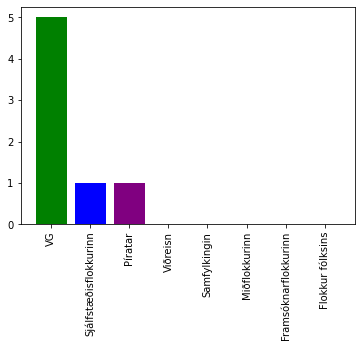

In [574]:
plot_flokk(dummy)

In [40]:
party_color = {'VG': 'green',
               'Sjálfstæðisflokkurinn': 'blue',
               'Píratar': 'purple',
               'Viðreisn': 'orange',
               'Samfylkingin': 'red', 
               'Miðflokkurinn': 'blue',
               'Framsóknarflokkurinn': 'green', 
               'Flokkur fólksins': 'yellow'
              }

In [575]:
current_member_hits = dict()
current_party_hits = dict()
for fl in current_flokkar:
    current_party_hits[fl] = 0


(54412, 5)

In [79]:
for i in tqdm.trange(2000,4000):
    art_text = data_playground.iloc[i]["text"]
    #print(data_playground.iloc[i]["title"])
    current_member_hits, current_party_hits = count_hits(art_text, current_member_party, current_member_hits, current_party_hits)
    
print(sort_dict(current_member_hits))
print(sort_dict(current_party_hits))

100%|██████████| 2000/2000 [25:36<00:00,  1.30it/s] 

{'Bjarni Benediktsson': 65, 'Katrín Jakobsdóttir': 58, 'Sigmundur Davíð Gunnlaugsson': 29, 'Guðlaugur Þór Þórðarson': 28, 'Sigurður Ingi Jóhannsson': 24, 'Svandís Svavarsdóttir': 19, 'Ásmundur Einar Daðason': 16, 'Lilja Alfreðsdóttir': 16, 'Áslaug Arna Sigurbjörnsdóttir': 15, 'Þórhildur Sunna Ævarsdóttir': 10, 'Jón Gunnarsson': 10, 'Guðmundur Ingi Guðbrandsson': 10, 'Logi Einarsson': 7, 'Ásmundur Friðriksson': 6, 'Halldóra Mogensen': 6, 'Bjarkey Olsen Gunnarsdóttir': 6, 'Bergþór Ólason': 6, 'Andrés Ingi Jónsson': 6, 'Óli Björn Kárason': 5, 'Willum Þór Þórsson': 5, 'Hildur Sverrisdóttir': 5, 'Líneik Anna Sævarsdóttir': 4, 'Inga Sæland': 4, 'Stefán Vagn Stefánsson': 3, 'Njáll Trausti Friðbertsson': 3, 'Helga Vala Helgadóttir': 3, 'Björn Leví Gunnarsson': 3, 'Birgir Þórarinsson': 3, 'Þórarinn Ingi Pétursson': 2, 'Vilhjálmur Árnason': 2, 'Steinunn Þóra Árnadóttir': 2, 'Haraldur Benediktsson': 2, 'Hanna Katrín Friðriksson': 2, 'Halla Signý Kristjánsdóttir': 2, 'Þórunn Sveinbjarnardóttir': 1

In [84]:

import json
with open("current_member_hits.json", "w") as fh:
    fh.write(json.dumps(current_member_hits))
with open("current_party_hits.json", "w") as fh:
    fh.write(json.dumps(current_party_hits))


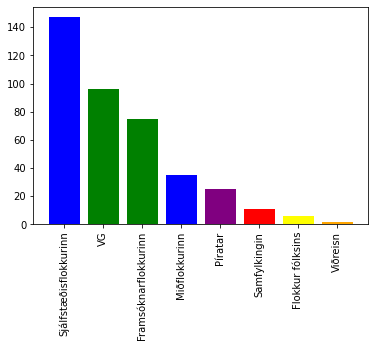

In [80]:
plot_flokk(sort_dict(current_party_hits))

In [81]:
def plot_member(bok):
    plt.figure(figsize=(6, 10))
    plt.barh(list(bok.keys()), bok.values())
    plt.show()
    
    # plt.barh(list(range(len(bok.keys()))), bok.values())
    # 
    # plt.ylabel(list(bok.keys()))
    # plt.yticks(rotation=90)
    # plt.show()

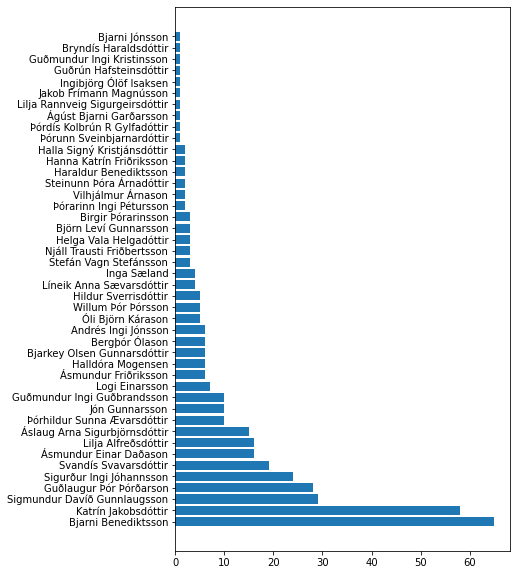

In [82]:
plot_member(sort_dict(current_member_hits))

Flokka stóran flokk eins og playground
Gera tölfræðina skiljanlega og fallega

Halda utan um hvaða greinar innihalda alþingismenn
Ath hvort við getum flokkað topic eitthvað í þeim greinum

Gera glærur
Æfa fyrirlestur

